In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
import numpy as np
from typing import Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

In [56]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [ ]:
DATA_PATH = Path("../data")

df_withdrawals = pd.read_parquet(DATA_PATH / "zrive_advertiser_withdrawals.parquet")
df_advertiser = pd.read_parquet(DATA_PATH / "zrive_dim_advertiser.parquet")
df_monthly = pd.read_parquet(DATA_PATH / "zrive_fct_montly_snapshot_advertiser.parquet")

full_data = pd.read_parquet(DATA_PATH / "full_data.parquet")
processed_data = pd.read_parquet(DATA_PATH / "processed_data.parquet")


In [ ]:
processed_data = processed_data.drop("monthly_avg_ad_price", axis=1)
processed_data = processed_data.drop("monthly_distinct_ads", axis=1)

## Baseline

In [75]:
from sklearn.metrics import accuracy_score

y_pred = [0] * len(processed_data)
class_report = classification_report(processed_data['churn'], y_pred)
print(f'Baseline 0 - Accuracy: {class_report}')


c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline 0 - Accuracy:               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     51993
         1.0       0.00      0.00      0.00      4342

    accuracy                           0.92     56335
   macro avg       0.46      0.50      0.48     56335
weighted avg       0.85      0.92      0.89     56335



c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline 1:
               precision    recall  f1-score   support

         0.0       0.92      0.95      0.94     51993
         1.0       0.09      0.06      0.07      4342

    accuracy                           0.88     56335
   macro avg       0.51      0.51      0.50     56335
weighted avg       0.86      0.88      0.87     56335



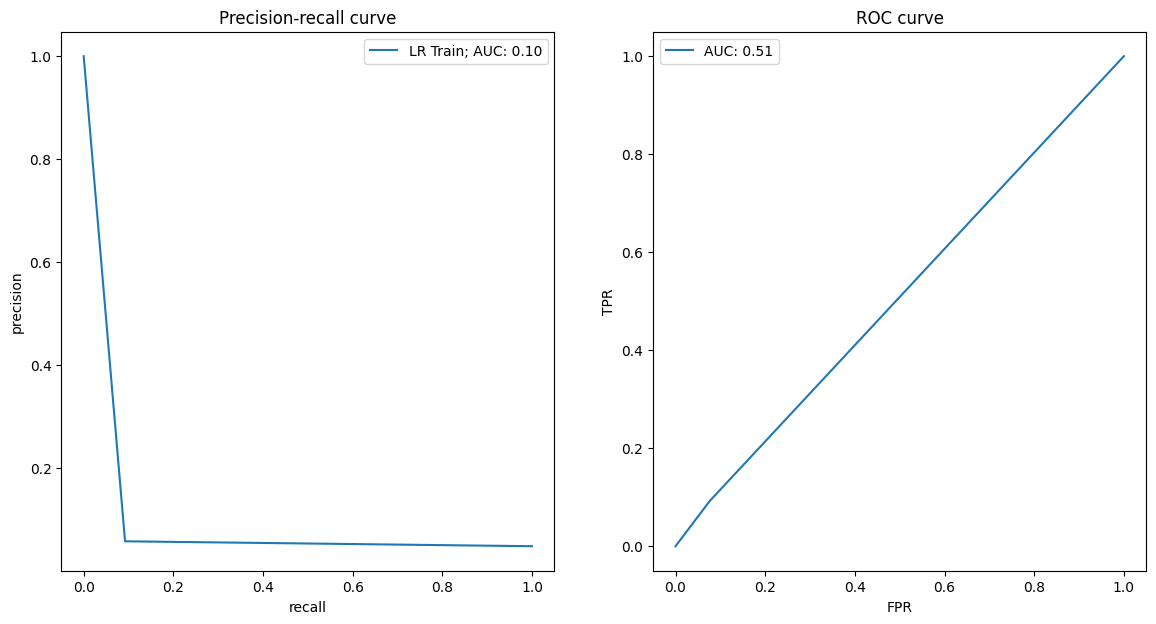

In [ ]:
processed_data['baseline_1_pred'] = ((processed_data['monthly_leads'] == 0) & (processed_data['monthly_visits'] == 0)).astype(int)

print("Baseline 1:\n", classification_report(processed_data['churn'], processed_data['baseline_1_pred']))


plot_metrics(
    f"LR Train", y_pred=processed_data['churn'], y_test=processed_data['baseline_1_pred']
    )


In [88]:
processed_data['baseline_1_prob']

0        0.000000
1        0.333333
3        0.000000
4        0.000000
5        0.000000
           ...   
57095    1.000000
57096    0.500000
57097    0.000000
57098    0.333333
57099    1.000000
Name: baseline_1_prob, Length: 56335, dtype: float64

In [89]:
import numpy as np

# Leads bajos => alta probabilidad de churn
max_leads = processed_data['monthly_leads'].median()
processed_data['baseline_1_prob'] = 1 - (processed_data['monthly_leads'] / max_leads).clip(upper=1)


plot_metrics(
    f"LR Train", y_pred=processed_data['churn'], y_test=processed_data['baseline_1_prob']
    )


ValueError: continuous format is not supported

In [57]:
train_df = processed_data[
    (processed_data['month_period'] >= '202303') &
    (processed_data['month_period'] < '202401')
]

val_df = processed_data[processed_data['month_period'] == '202401']

label_col = 'churn'

In [35]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

## Train

In [ ]:
# model basic
lr = LogisticRegression(
    class_weight="balanced",
)

lr.fit(X_train[train_cols], y_train).


LogisticRegression(class_weight='balanced')

In [ ]:
y_train_pred_LogReg_ridge_model = lr.predict(X_train[train_cols])

print(
    "Report Train:\n", classification_report(y_train, y_train_pred_LogReg_ridge_model)
)


Report Train:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     22619
         1.0       0.06      0.01      0.02      1903

    accuracy                           0.91     24522
   macro avg       0.49      0.50      0.49     24522
weighted avg       0.86      0.91      0.88     24522



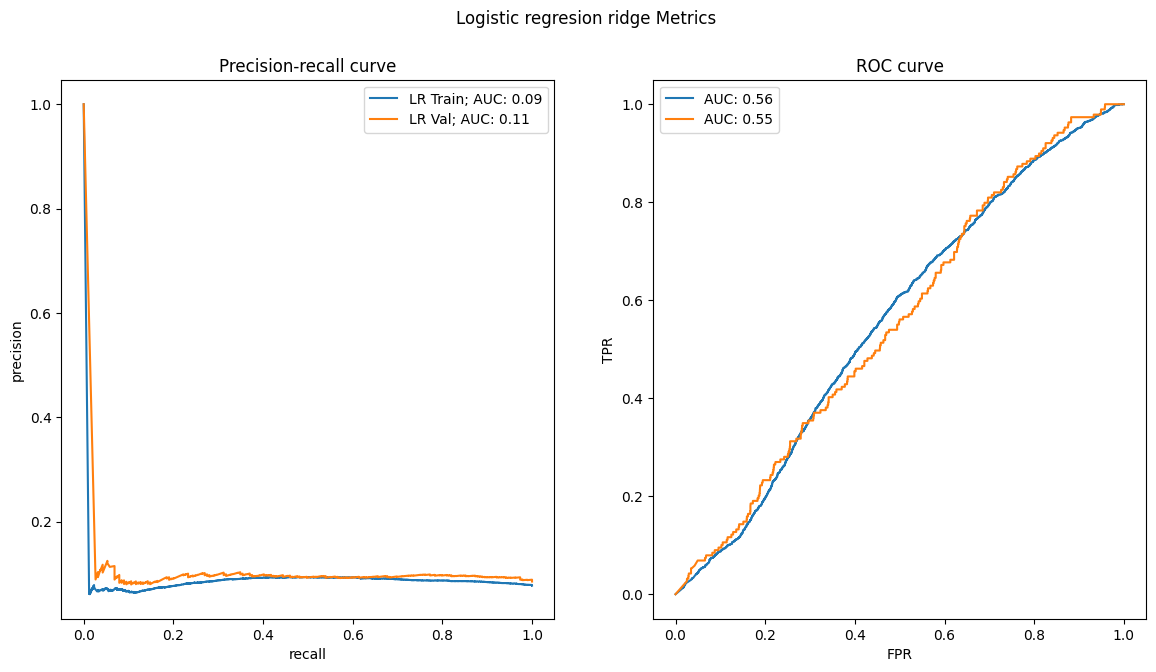

In [53]:
y_train_pred_LogReg_model = lr.predict(X_train[train_cols])
y_test_pred_LogReg_model = lr.predict(X_val[train_cols])

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Logistic regresion ridge Metrics")


val_proba = lr.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"LR Train", y_pred=val_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"LR Val", y_pred=val_proba, y_test=val_df[label_col], figure=(fig1, ax1)
)